In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pylops
import pyproximal
from scipy.signal import filtfilt, convolve
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
 
np.random.seed(1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## An introduction to proximal solvers for engineers
### XX/XX/XX @ Luna Innovation 
### Instructor: Matteo Ravasi, Assistant Professor - KAUST

## About the Instructor

### Matteo Ravasi, Assistant Professor - KAUST

Career:

- Assistant Professor, King Abdullah University of Science and Technology (KAUST) - 2021-Now
- Research Geophysicist, Statoil/Equinor - 2015-2020
- Ph.D in Geophysics, University of Edinburgh - 2012-2015
- BSc & MSc in Telecommunication Engineering, Politecnico di Milano - 2006-2011

Extra:

- Main developer and mantainer of the [PyLops](http://github.com/pylops) framework
- Amateur photographer
- Inter Milan supporter

## Motivation

Gradient-based optimization:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (nonlinear)}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (linear)}
$$

## Motivation

Proximal-based optimization:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{||\mathbf{m}||_1} \qquad \textrm{L1-regularized / Sparse inversion}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{||\mathbf{M}||_*} \qquad \textrm{Low-rank matrix approximation} 
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{TV(\mathbf{m})} \qquad \textrm{TV-regularized inversion} 
$$

and 

$$
\underset{\mathbf{m} \color{blue}{\in C}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2  \qquad \textrm{Constrained inversion}
$$

## Motivation

L1 norm:
    
$$
||\mathbf{m}||_1=\sum_i m_i
$$

Nuclear norm:
    
$$
||\mathbf{M}||_*=\sum_i \sigma_i
$$

Total-variation norm:

$$
TV(\mathbf{m})=\sqrt{\partial_x \mathbf{m}^2 + \partial_z \mathbf{m}^2}
$$

What do these functions have in common? **Non-smooth function**

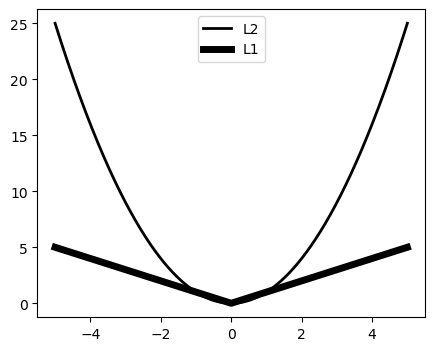

In [3]:
plt.figure(figsize=(5, 4))
x = np.arange(-5, 5.01, 0.01)
plt.plot(x, x**2, 'k', lw=2, label='L2')
plt.plot(x, np.abs(x), 'k', lw=5, label='L1')
plt.legend();

## Notation

The following convention will be used in the rest of the course:

- $\mathbf{m} \in \mathbb{R}^M$: model. Quantity that we are interested to know and we think affects the observed data - human organs, rock properties, pressure, atmosferic pressure, ...
- $\mathbf{d} \in \mathbb{R}^N$: observed data. Quantity that we can physicially measure - CT scan, seismic data, production data, precipitation, ...
- $\mathbf{G} \in \mathbb{R}^{M \rightarrow N}$ (or $\mathcal{G}$): modelling operator. Set of equations that we think can explain the data by nonlinear/linear combination of model parameters - Radon, seismic convolution model, Navier-stoke (or any other PDE)...

## Denoising

We want to reconstruct a blocky 1D signal from noisy measuments:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla^2 \mathbf{m}||_2^2
$$

or 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla\mathbf{m}||_1
$$

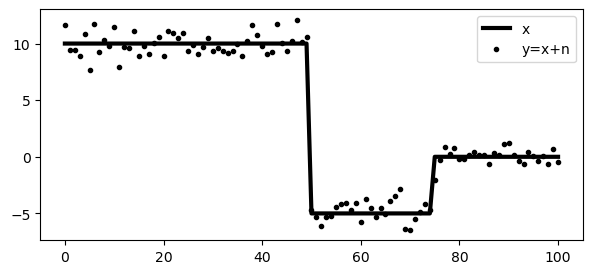

In [4]:
nx = 101
x = np.zeros(nx)
x[: nx // 2] = 10
x[nx // 2 : 3 * nx // 4] = -5

Iop = pylops.Identity(nx)
n = np.random.normal(0, 1, nx)
y = Iop * x + n

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.legend();

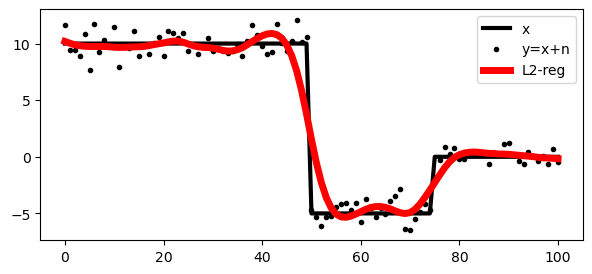

In [5]:
D2op = pylops.SecondDerivative(nx, edge=True)
alpha = 1e2

xinv = pylops.optimization.leastsquares.regularized_inversion(
    Iop, y, [D2op], epsRs=[np.sqrt(alpha / 2)], **dict(iter_lim=30))[0]

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.legend();

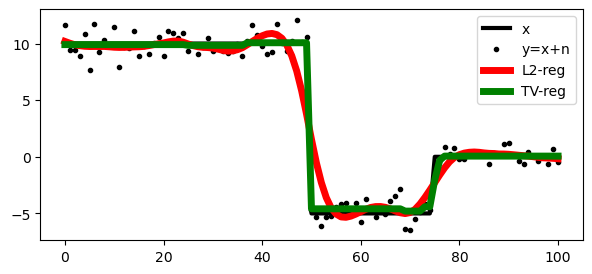

In [6]:
D2op = pylops.FirstDerivative(nx, edge=True, kind='backward')
f = pyproximal.L2(Iop, y, niter=20)
g = pyproximal.L1(2.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xtv = pyproximal.optimization.primal.LinearizedADMM \
        (f, g, D2op, np.zeros_like(x),
         tau, mu, niter=500, show=False)[0]

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.plot(xtv, "g", lw=5, label="TV-reg")
plt.legend();

## The anatomy of a proximal solver

In this course, we will always start from the following general optimization problem:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} f(\mathbf{m}) + g(\mathbf{Lm})
$$

where:

- $f(\mathbf{m})$: main term (i.e., data misfit term). Usually smooth (i.e., differentiable), in some cases can be non-smooth (e.g., indicator function).
- $g(\mathbf{Lm})$: secondary term (i.e., regularization term). Usually non-smooth but *proximable*. It can also be a sum of multiple functions $g(\mathbf{m})=\sum_i g_i(\mathbf{Lm})$.
- $\mathbf{L} \in \mathbb{R}^{M \rightarrow K}$: linear operator.

## The anatomy of a proximal solver

Any proximal solver comprises of the following operations:

- linear operator (forward and adjoint): $\mathbf{L}$ and $\mathbf{L}^H$
- gradient or linear/nonlinear solve: $\partial f$ or $ {\mathrm{argmin}} f(\mathbf{m}) + ...$
- proximal operator: $prox_g$ (and $prox_f$)
- simple operations on vectors: dot-products, scalar-vector products, etc.

A software that implements proximal solvers should handle these 4 components.

## The anatomy of a proximal solver (in Python)

Any proximal solver comprises of the following operations:

- linear operator (forward and adjoint): $\mathbf{L}$ and $\mathbf{L}^H$ $\rightarrow \color{blue}{\text{PyLops}}$
- gradient or linear/nonlinear solve: $\partial f$ or $ {\mathrm{argmin}} f(\mathbf{m}) + ...$ $\rightarrow \color{blue}{\text{PyProximal}}$
- proximal operator: $prox_g$ (and $prox_f$) $\rightarrow \color{blue}{\text{PyProximal}}$
- simple operations on vectors: dot-products, scalar-vector products, etc. $\rightarrow \color{blue}{\text{NumPy}}$

A software that implements proximal solvers should handle these 4 components.

## A prelude of what is about to come...

Given:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} f(\mathbf{m}) + g(\mathbf{Lm})
$$

we can use:

- gradient-based optimizers if $f$ (and $g$) are differentiable;
- proximal point if $f$ is proximable and $g=0$;
- proximal gradient if $f$ is differentiable, $g$ is proximable, and $\mathbf{L}=\mathbf{I}$;
- HQS/ADMM if $f$ and $g$ are proximable and $\mathbf{L}=\mathbf{I}$;
- ADMM if $f=\frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2$, $g$ is proximable, and $\mathbf{L}=\mathbf{I}$ is any linear operator;
- Chambolle-Pock Primal Dual if $f$ and $g$ are proximable and $\mathbf{L}$ is any linear operator.

## A prelude of what is about to come...

<img src="../Figs/ProximalDecisionTree.png" width="700" align="center">

## Gradient-based optimization

Let's define the general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is a **smooth** convex function (e.g. L2 norm).

This can be solved via the **Gradient Descent** algorithm:

$$
\mathbf{m}_{k+1} = \mathbf{m}_k - \alpha \nabla f(\mathbf{m}_k)
$$

where $\alpha$ is the step-size.

We can rewrite this as a Fixed-Point algorithm defining $\mathcal{T}(\mathbf{m})=I- \alpha \nabla f(\mathbf{m})$:

$$
\mathbf{m}_{k+1} = \mathcal{T}(\mathbf{m}_k)
$$

and when the fixed-point $\mathbf{m}_*$ is reached we have found the solution!

## Gradient-based optimization

Two special cases commonly used in inverse problem theory are:

- nonlinear data-fitting term: $f_{nl}=\frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2$
- linear data fitting term: $f_{l}=\frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2$

whose derivatives are:

- nonlinear: $\nabla f_{nl}(\mathbf{m}) = - \mathbf{G}^H (\mathbf{d} - \mathbf{G}\mathbf{m})$
- linear:  $\nabla f_l (\mathbf{m}) = - \mathbf{G}^H (\mathbf{d} - \mathcal{G}(\mathbf{m}))$ ($\mathbf{G}$ is the Jacobian of $\mathcal{G}(\mathbf{m})$).

## Gradient-based optimization - linear

For linear problems of the kind $\mathbf{d} = \mathbf{G}\mathbf{m}$:

- square: $\hat{\mathbf{m}} = \mathbf{G}^{-1} \mathbf{d}$
- overdetermined ($f=\frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2$): $\hat{\mathbf{m}} = (\mathbf{G}^H\mathbf{G})^{-1} \mathbf{G}^H \mathbf{d}$
- underdetermined ($f=\frac{1}{2} ||\mathbf{m}||_2^2 s.t. \mathbf{d} = \mathbf{G}\mathbf{m}$): $\hat{\mathbf{m}} = \mathbf{G}^H (\mathbf{G}\mathbf{G}^H)^{-1}  \mathbf{d}$

To obtain $\mathbf{G}^{-1}/ (\mathbf{G}^H\mathbf{G})^{-1} / (\mathbf{G}\mathbf{G}^H)^{-1}$:
- direct solvers: LU, QR, ..
- iterative solvers: CG, LSQR, ...

## Dense matrices vs linear operators

For iterative solvers, one must simply know how to compute $\mathbf{G}\mathbf{x}$ (forward) and $\mathbf{G}^H\mathbf{y}$ (adjoint) --> useful when $\mathbf{G}$ is too large to be inverted and/or stored.

- Dense matrix: a place in computer memory where to store $N \times M$ elements of $\mathbf{G}$;
- Linear operator: a piece of computer code that can perform forward and adjoint operations without the need to store an explicit matrix.

**Dot-test** : mathematical equality used to verify correctness of forward/adjoint pair

$$(\mathbf{G}\cdot \mathbf{u})^H\mathbf{v} = \mathbf{u}^H(\mathbf{G}^H \cdot \mathbf{v})$$

## Dense matrices vs linear operators

First derivative (forward):

$$
\mathbf{D} = \begin{bmatrix} -1 & 1 & ... & 0 & 0 \\ -0.5 & 0 & 0.5 & ... & 0 \\ ... \\ 0 & 0 & ... & -1 & 1 \\ \end{bmatrix} 
$$

```python
def _matvec(x):
    y = np.zeros(x.size, self.dtype)
    y[1:-1] = (0.5 * x[2:] - 0.5 * x[0:-2]) / self.sampling
    # edges
    y[0] = (x[1] - x[0]) / self.sampling
    y[-1] = (x[-1] - x[-2]) / self.sampling
    return y
```

## Dense matrices vs linear operators

First derivative (adjoint):

$$
\mathbf{D}^H = \begin{bmatrix} -1 & -0.5 & ... & 0 & 0 \\ 1 & 0 & -0.5 & ... & 0 \\ ... \\ 0 & 0 & ... & -0.5 & 1 \\ \end{bmatrix}
$$

```python
def _rmatvec(x):
    y = np.zeros(x.size, self.dtype)
    y[0:-2] -= (0.5 * x[1:-1]) / self.sampling
    y[2:] += (0.5 * x[1:-1]) / self.sampling
    # edges
    y[0] -= x[0] / self.sampling
    y[1] += x[0] / self.sampling
    y[-2] -= x[-1] / self.sampling
    y[-1] += x[-1] / self.sampling
    return y
```

## Dense matrices vs linear operators

Time to practice: [EX1](https://github.com/mrava87/ProximalTeaching/blob/main/examples/FFTLinOp.ipynb)

## Proximal operator

$$
prox_{\tau f} (\mathbf{v}) = (I+ \tau \partial f)^{-1}(\mathbf{x})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m}) + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

<img src="../Figs/ProximalOp.png" width="500" align="center">

Source: Parikh N., Proximal Algorithms.

## Proximal operator

An inverse problem at every step of the iterative scheme... bahhh!!

Luckily many proximal operators have **closed-form** solution:

$$
\text{Squared L2:} \;
prox_{\tau ||\cdot||_2^2} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_2^2 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = \frac{\mathbf{v}}{1+\tau}
$$

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = soft(\mathbf{v}, \tau) \quad \text{(soft-thresholding)}
$$  

$$
\text{Box constraint:} prox_{Box_{[l, u]}} (\mathbf{v})  = \underset{\mathbf{m} \in Box} {\mathrm{argmin}} \;  \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = min\{ max \{\mathbf{v}, l\}, u \}
$$ 

See Parikh N., Proximal Algorithms for an extensive list of Proximal operators.

## Proximal operator

Let's look at one (just one, I promise) derivation:

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

First, let's realize the problem is separable with respect to both $\mathbf{v}$ and $\mathbf{m}$. For $M=3$:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; |m_1| + |m_2| + |m_3| + \frac{1}{2\tau}((m_1-v_1)^2 + (m_2-v_2)^2 + (m_3-v_3)^2)
$$

so for any $i=1,2,3$:

$$
\underset{m_i} {\mathrm{argmin}} \; |m_i| + \frac{1}{2\tau}(m_i-v_i)^2 = \underset{m_i} {\mathrm{argmin}} \; \tau|m_i| + \frac{1}{2}(m_i-v_i)^2 = \mathcal{l}(m_i)
$$

## Proximal operator

We observe that $m_i$ can be either negative, zero, or positive and we treat the three cases separately:

- $m_i > 0$: $\partial \mathcal{l}(m_i) / \partial m_i =  m_i-v_i + \tau = 0 \rightarrow m_i = v_i - \tau \;  (v_i > \tau)$
- $m_i < 0$: $\partial \mathcal{l}(m_i) / \partial m_i =  m_i-v_i - \tau = 0 \rightarrow m_i = v_i + \tau \;  (v_i < -\tau)$
- $u_i = 0$: $\partial \mathcal|(m_i)| / \partial m_i = \in [-1,1] \rightarrow m_i = 0 \; (-\tau \le v_i \ge \tau)$

One of many sources: https://www.youtube.com/watch?v=LABiFM79W6M

In [7]:
import pyproximal

# L2
l2sq = pyproximal.L2(sigma=2.)

x = np.arange(3)
print('L2sq: %.2f' % l2sq(x), ', L2sq prox', l2sq.prox(x, 2.))

# L1
l1 = pyproximal.L1(sigma=1.)

x = np.arange(3)
print('L1: %.2f' % l1(x), ', L1 prox', l1.prox(x, 0.3))

L2sq: 5.00 , L2sq prox [0.  0.2 0.4]
L1: 3.00 , L1 prox [0.  0.7 1.7]


## Proximal operator

Other important proximal operators are:

$$
\text{Affine Set:} \;
prox_{\mathbf{Gx}=\mathbf{d}} (\mathbf{v}) = \mathbf{v} - \mathbf{G}^H(\mathbf{G}\mathbf{G}^H)^{-1}(\mathbf{Gv}-\mathbf{d})
$$

$$
\text{L2 Ball:} \;
prox_{\tau ||\cdot - \mathbf{c}||_2 \leq r} (\mathbf{v}) = \mathbf{c} + \frac{r}{max\{ ||\mathbf{v} - \mathbf{c}||_2, r\}}(\mathbf{v} - \mathbf{c})
$$

$$
\text{L0:} \;prox_{\tau ||\cdot||_0} (\mathbf{v})  = hard(\mathbf{v}, \tau) \quad \text{(hard-thresholding)}
$$  

$$ 
\text{Nuclear Norm:} \;prox_{\tau \sigma \|\cdot\|_*}(\mathbf{X}) = \mathbf{U} diag \{ prox_{\tau \sigma \|\cdot\|_1}(\boldsymbol\lambda) \} \mathbf{V}^H
$$

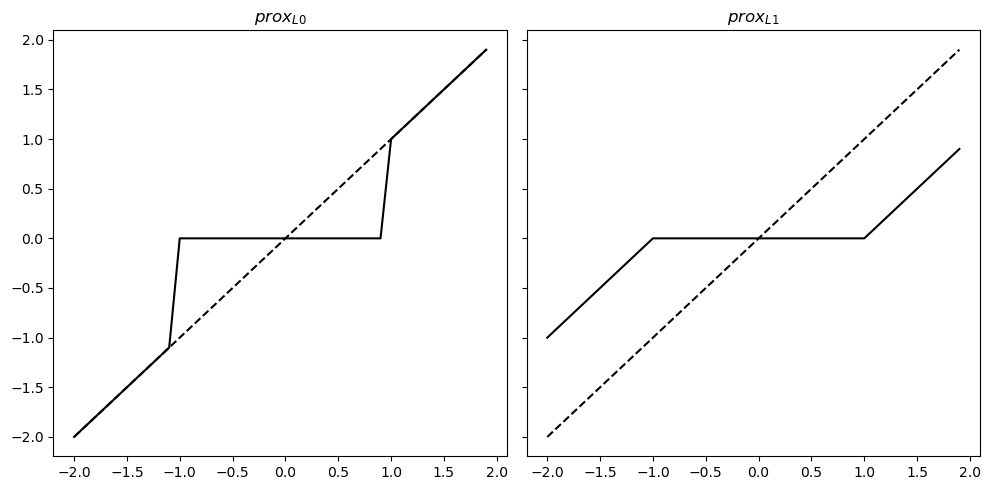

In [8]:
# LO and L1
l0 = pyproximal.L0()
l1 = pyproximal.L1()

x = np.arange(-2, 2, 0.1)
xp0 = l0.prox(x, 1.)
xp1 = l1.prox(x, 1.)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
axs[0].plot(x, xp0, 'k')
axs[0].plot(x, x, '--k')
axs[0].set_title(r'$prox_{L0}$')
axs[1].plot(x, xp1, 'k')
axs[1].plot(x, x, '--k')
axs[1].set_title(r'$prox_{L1}$')
plt.tight_layout();

## Proximal operator

Finally, let's consider a few useful properties of the proximal operator:


$$
\text{Separable function:} f(\mathbf{x})=\sum_{i=1}^{M} f_i(x_i), \; prox_{\tau f} (\mathbf{v}) = [prox_{\tau f_1} (v_1),prox_{\tau f_2} (v_2), ..., prox_{\tau f_M} (v_M)]^T
$$ 

$$
\text{Pre-composition:} g(\mathbf{x})=f(a \mathbf{x} + b)  \; (a>0) \;\; prox_{\tau g} (\mathbf{v}) =
            prox_{a \tau f} (\mathbf{v})
$$ 

$$
\text{Post-composition:} g(\mathbf{x})=a f(\mathbf{x}) + b \; (a>0) \;\; prox_{\tau g} (\mathbf{v}) =
            \frac{1}{a} (
            prox_{a^2 \tau f} (a \mathbf{v} + b) - b)
$$ 

$$
\text{Affine addition:} \; prox_{\tau (f(\mathbf{x}) +
        \mathbf{a}^T \mathbf{x}) + b} (\mathbf{v})  = prox_{\tau f} (\mathbf{v} - \tau \mathbf{a})
$$ 



## Optimizing convex functionals

Let's define the general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is now a **non-smooth** convex function (e.g., L1 norm).

This can be solved via the **Proximal Point** algorithm:

$$
\mathbf{m}_{k+1} = prox_{\tau f} (\mathbf{m}_k) 
$$

Let's see how this works with a simple example:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1
$$

## Optimizing mixed (smooth & non-smooth) functionals

Let's consider the case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{m})
$$

where $f$ is a smooth function (e.g., squared L2 norm) and $g$ is possibly non-smooth, convex function (e.g. L1 norm);

A smart way of solving this general problem is to use the **Forward-Backward splitting** algorithm:

$$
0 \in \nabla f(\mathbf{m}) + \partial g(\mathbf{m})\\
0 \in \mathbf{m}/\tau - \mathbf{m}/\tau + \nabla f(\mathbf{m}) + \partial g(\mathbf{m})\\
(I-\tau \nabla f)(\mathbf{m}) \in (I+\tau \partial g)(\mathbf{m})\\
\mathbf{m}_* = (I+\tau \partial g)^{-1} (I-\tau \nabla f)(\mathbf{m}_*)\\
$$

In [9]:
def callback(x):
    xhist.append(x)

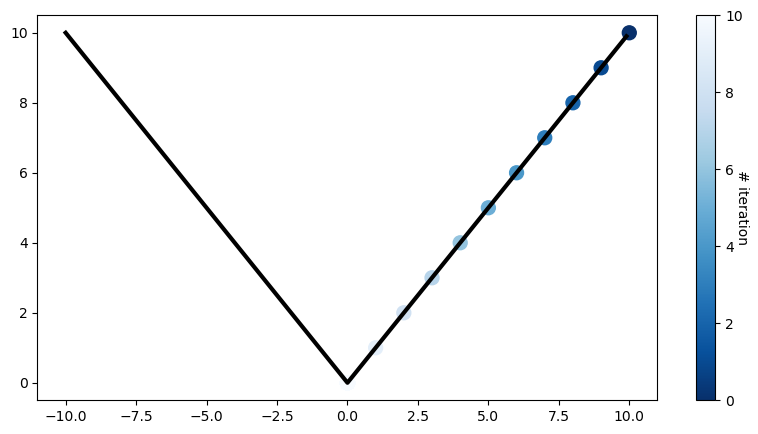

In [10]:
f = pyproximal.L1()
x0 = np.array([10,])

xhist = [x0, ]
x = pyproximal.optimization.primal.ProximalPoint(f, x0, tau, niter=20, callback=lambda x: callback(x))

plt.figure(figsize=(10, 5))
plt.plot(np.arange(-10, 10, 0.1), np.abs(np.arange(-10, 10, 0.1)), "k", lw=3, label="x")
plt.scatter(xhist, np.abs(xhist), c=np.arange(21), s=100, cmap='Blues_r', vmin=0, vmax=10);
cbar = plt.colorbar()
cbar.ax.set_ylabel('# iteration', rotation=270);

## Optimizing mixed (smooth & non-smooth) functionals

Let's consider the case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{m})
$$

The **Forward-Backward splitting** algorithm reads as:
    
$$
\mathbf{m}_{k+1} = prox_{\tau_k f} (\mathbf{m}_k - \tau_k \nabla f(\mathbf{m}_k))\\
$$

where $\tau_k \in (0, 1/L]$ with $L$ being the Lipschitz constant of $\nabla f$.

## Optimizing mixed (smooth & non-smooth) functionals

- To add Lipschitz constant of $\nabla f$ = max eig of Hessian... show an example for L2
- Say if too difficult backtracking and explain how it works
- Talk about acceleration

## Optimizing mixed (smooth & non-smooth) functionals

You may recognize the famous ISTA algorithm here!

When $f=\frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2$ and $g=||\mathbf{m}||_1$, we have:

$$
\mathbf{m}_{k+1} = prox_{||\cdot||_1} (\mathbf{m}_k - \mathbf{G}^H(\mathbf{G}\mathbf{m}_k-\mathbf{d}))\\
$$


## Spiky deconvolution

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wm}||_2^2 + \alpha ||\mathbf{m}||_1
$$

where $\mathbf{d}$ is a band-limited signal and $\mathbf{W}$ is the convolution operator with a prescribed wavelet.

In [11]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

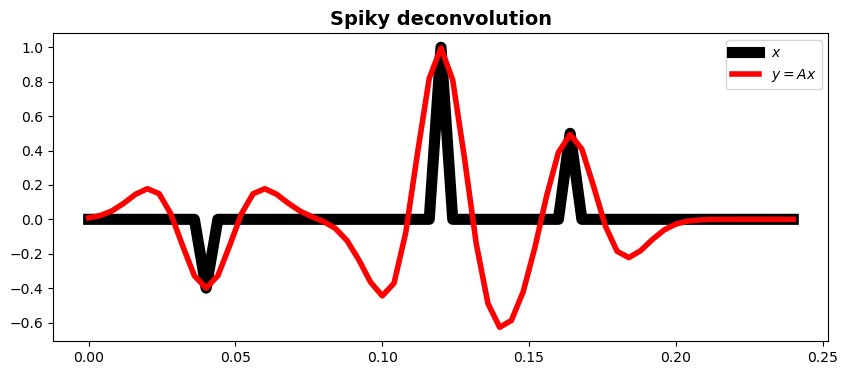

In [12]:
nt = 61
dt = 0.004
t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

h, th, hcenter = pylops.utils.wavelets.ricker(t[:21], f0=20)
Wop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
y = Wop * x

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
ax.set_title("Spiky deconvolution", fontsize=14, fontweight="bold")
ax.legend();

In [13]:
# Least-squares
xls = Wop / y

# L1-regularized
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Wop, b=y)
L = np.abs((Wop.H * Wop).eigs(1)[0])
tau = 0.95 / L
eps = 1e-1
niter = 1000

xista_err, xfista_err = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xista_err))
xfista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xfista_err))

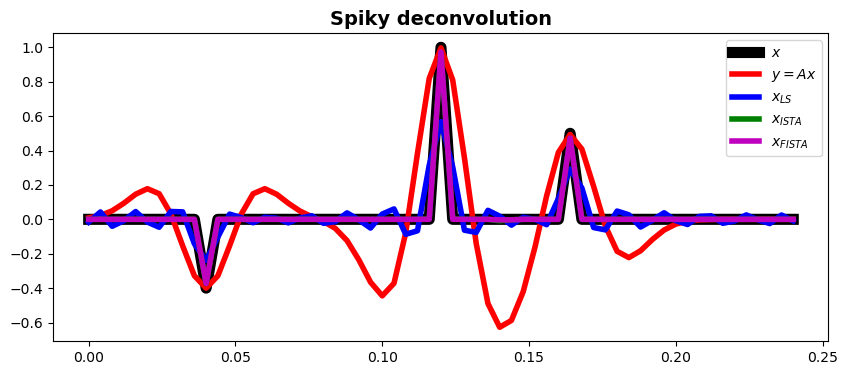

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
ax.plot(t, xls, "b", lw=4, label=r"$x_{LS}$")
ax.plot(t, xista, "g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Spiky deconvolution", fontsize=14, fontweight="bold")
ax.legend();

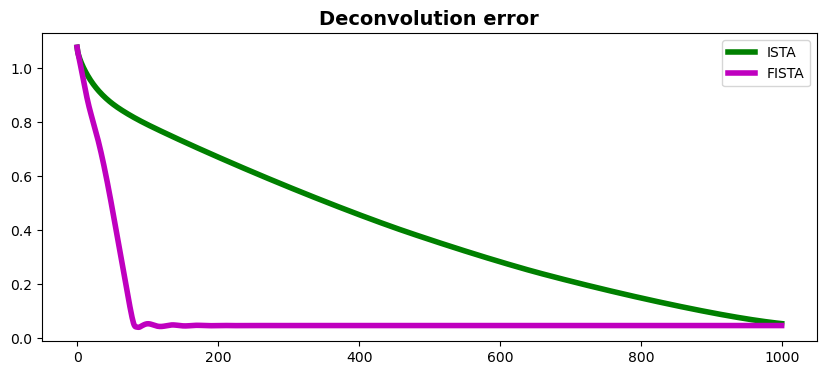

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(xista_err, "g", lw=4, label="ISTA")
ax.plot(xfista_err, "m", lw=4, label="FISTA")
ax.set_title("Deconvolution error", fontsize=14, fontweight="bold")
ax.legend();

## Optimizing mixed (smooth & non-smooth) functionals

When both where $f$ and $g$ are non-smooth, convex functions, the Proximal gradient algorithm (or ISTA) cannot be used.

In order to solve this problem, a two steps procedure is required:

- Splitting: $\mathbf{y}=\mathbf{m}$, such that

$$
\underset{\mathbf{m}, \mathbf{y}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{y})
$$

- Augmented Lagrangian: $\text{arg} \underset{\mathbf{m},\mathbf{y}} {\mathrm{min}} \underset{\mathbf{z}}  {\mathrm{max}} \mathscr{L}$, where 
$$
\mathscr{L}=f(\mathbf{m}) + g(\mathbf{y}) + \frac{\rho}{2}||\mathbf{m}-\mathbf{y}||_2^2 + \mathbf{z}^T(\mathbf{m}-\mathbf{y})
$$

- Alternating minimization:

$$
\mathbf{m}_k = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}, \mathbf{y}_{k-1}, \mathbf{z}_{k-1}) = prox_{\tau f}(\mathbf{y}_{k-1}-\mathbf{z}_{k-1}) \\
\mathbf{y}_k = \underset{\mathbf{y}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}, \mathbf{z}_{k-1}) = prox_{\tau g}(\mathbf{m}_k+\mathbf{z}_{k-1}) \\
\mathbf{z}_k = \underset{\mathbf{z}} {\mathrm{argmax}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}_k, \mathbf{z}) = \mathbf{z}_{k-1} + \mathbf{m}_k - \mathbf{y}_k
$$

This is the famous **ADMM** algorithm.

## Optimizing mixed (smooth & non-smooth) functionals

Similarly, when $g=||\mathbf{Lm}||_p$, a number of additional steps are required to optimize the associated functional:

$$
\text{arg} \underset{\mathbf{m}} {\mathrm{min}} \quad f(\mathbf{m}) + g(\mathbf{Lm})
$$

- Splitting: $\mathbf{y}=\mathbf{Lm}$
- Augmented Lagrangian: $\text{arg} \underset{\mathbf{m},\mathbf{y}} {\mathrm{min}} \underset{\mathbf{z}}  {\mathrm{max}} \mathscr{L}$, where 
$$
\mathscr{L}=f(\mathbf{m}) + g(\mathbf{y}) + \frac{\rho}{2}||\mathbf{Lm}-\mathbf{y}||_2^2 + \mathbf{z}^T(\mathbf{Lm}-\mathbf{y})
$$

## Optimizing mixed (smooth & non-smooth) functionals

- Alternating minimization:

$$
\mathbf{m}_k = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}, \mathbf{y}_{k-1}, \mathbf{z}_{k-1}) \\
\mathbf{y}_k = \underset{\mathbf{y}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}, \mathbf{z}_{k-1}) = prox_{\tau g}(\mathbf{Lm}_{k} + \mathbf{z}_{k-1}) \\ \\
\mathbf{z}_k = \underset{\mathbf{z}} {\mathrm{argmax}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}_k, \mathbf{z}) = \mathbf{z}_{k-1} + \mathbf{Lm}_k - \mathbf{y}_k
$$

## ADMM for L2-L1 functionals

Let's now consider a special case where

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{Lm}||_1
$$

This reduces to:

$$
\mathbf{m}_k = (\mathbf{G}^H \mathbf{G} + \rho \mathbf{L}^H \mathbf{L})^{-1} (\mathbf{G}^H \mathbf{d} +  \rho \mathbf{L}^H(\mathbf{y}_{k-1} - \mathbf{z}_{k-1})) \\
\mathbf{y}_k = soft(\mathbf{Lm}_{k} + \mathbf{z}_{k-1}, \alpha / \rho) \\ \\
\mathbf{z}_k = \mathbf{z}_{k-1} + \mathbf{Lm}_k - \mathbf{y}_k
$$


## ADMM for L2-L1 functionals

Note that the first step is the proximal operator of the L2 squared norm of the following system of equations:

$$
\begin{bmatrix} 
\mathbf{G} \\
\sqrt{ \rho}\mathbf{L}
  \end{bmatrix} \mathbf{m} = 
\begin{bmatrix} 
\mathbf{d} \\
\sqrt{ \rho}(\mathbf{y}_{k-1} - \mathbf{z}_{k-1})
  \end{bmatrix}
$$

and can be solved directly or via any of the iterative scheme for least-squares inversion (e.g., CGLS, LSQR).



## Total-variation regularized inversion

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha TV(\mathbf{m}) \qquad \textrm{TV-regularized inversion}
$$

This can be seen as a special case of ADMM for L2-L1 functionals, as the isotropic TV is the $L_{2,1}$ norm of the gradients of $\mathbf{m}$.

**Problem**: MRI Imaging ($\mathbf{G}$ is the restricted 2D-FFT operator, $\mathbf{m}$ is an anatomical image)  - from Corona et al., 2021.

In [16]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

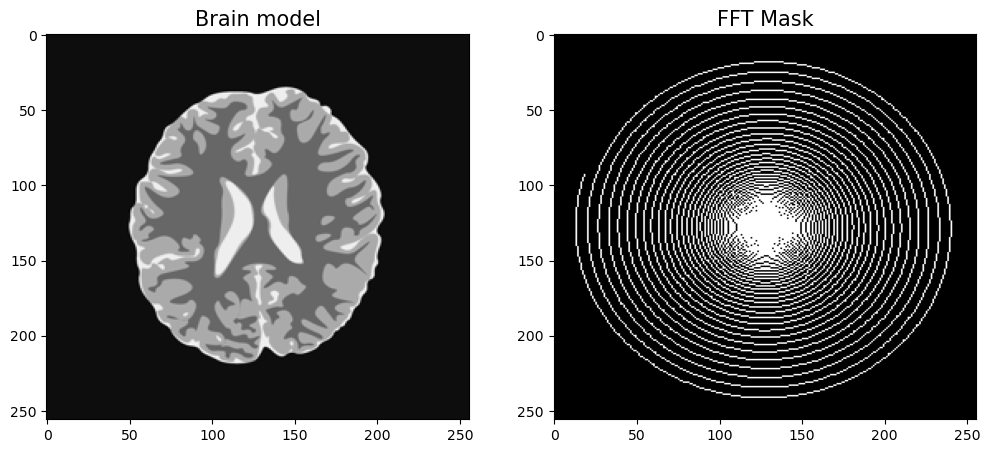

In [17]:
brain = loadmat('../data/brainphantom.mat')
mask = loadmat('../data/spiralsampling.mat')

brain = brain['gt']
mask = mask['samp']
mask_fft = np.fft.ifftshift(mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(brain, cmap='gray')
ax[0].axis('tight')
ax[0].set_title('Brain model', fontsize=15)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('FFT Mask', fontsize=15)
ax[1].axis('tight');

In [18]:
# Reconstruction operator
Fop = pylops.signalprocessing.FFT2D(dims=brain.shape)
Rop = pylops.Restriction(brain.size, np.where(mask_fft.ravel() == 1)[0], forceflat=True, dtype=np.complex128)
Dop = Rop * Fop

# Data
sigman = 0.
brain_fft = Fop * brain.ravel()
brain_fft = brain_fft.reshape(brain.shape)
d = Dop * brain.ravel()
d += np.random.normal(0, sigman, d.shape)

In [19]:
# Zero-filling reconstruction
brain_zero = mask_fft * brain_fft
brain_zero = Fop.H * brain_zero.ravel()
brain_zero = np.real(brain_zero.reshape(brain.shape))

In [20]:
# TV reconstruction
sigma = 0.04
l1 = pyproximal.proximal.L21(ndim=2, sigma=sigma)
l2 = pyproximal.proximal.L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
Gop = pylops.Gradient(dims=brain.shape, edge=True, kind='forward', dtype=np.complex128)

L = 8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
brain_tv = pyproximal.optimization.primaldual.PrimalDual(l2, l1, Gop, x0=np.zeros(brain.size), 
                                                         tau=tau, mu=mu, theta=1., 
                                                         niter=100, show=False)
brain_tv = np.real(brain_tv.reshape(brain.shape))

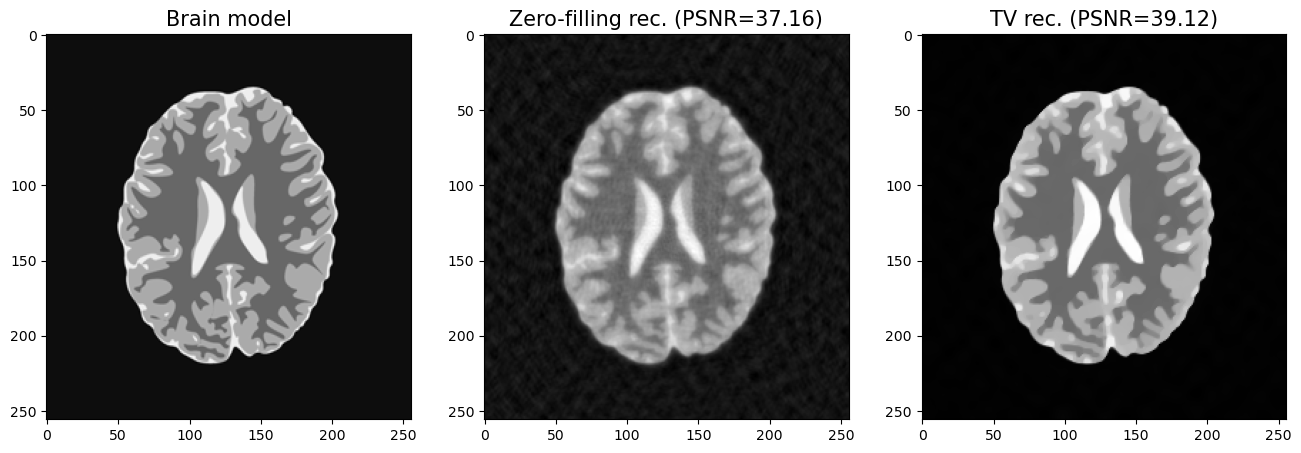

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].imshow(brain, cmap='gray')
ax[0].axis('tight')
ax[0].set_title('Brain model', fontsize=15)
ax[1].imshow(brain_zero, cmap='gray')
ax[1].set_title('Zero-filling rec. (PSNR=%.2f)' % PSNR(brain.ravel(), brain_zero.ravel()), fontsize=15)
ax[1].axis('tight')
ax[2].imshow(brain_tv, cmap='gray')
ax[2].set_title('TV rec. (PSNR=%.2f)' % PSNR(brain.ravel(), brain_tv.ravel()), fontsize=15)
ax[2].axis('tight');

## Nonlinear constrained inversion

The algorithms that we have discussed up until now can be easily extended to nonlinear problems. Consider:

$$
\underset{\mathbf{x}} {\mathrm{argmin}} \quad f(\mathbf{x}) \quad s.t. \quad \mathbf{x}
        \in I_{Box}
$$

The Proximal gradient algorithm simply becomes:

$$
\mathbf{m}_{k+1} = prox_{\delta I_{Box}} (\mathbf{x}_k - \nabla f(\mathbf{x}_k))\\
$$

In [22]:
def rosenbrock(x, y, a=1, b=10):
    f = (a - x)**2 + b*(y - x**2)**2
    return f

def rosenbrock_grad(x, y, a=1, b=10):
    dfx = -2*(a - x) - 2*b*(y - x**2) * 2 * x
    dfy = 2*b*(y - x**2)
    return dfx, dfy

def contour_rosenbrock(x, y):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Evaluate the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)

    # Plot the surface.
    surf = ax.contour(x, y, z, 200, cmap='gist_heat_r', vmin=-20, vmax=200,
                      antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax

class Rosebrock(pyproximal.proximal.Nonlinear):
    def setup(self, a=1, b=10, alpha=1.):
        self.a, self.b = a, b
        self.alpha = alpha
    def fun(self, x):
        return np.array(rosenbrock(x[0], x[1], a=self.a, b=self.b))
    def grad(self, x):
        return np.array(rosenbrock_grad(x[0], x[1], a=self.a, b=self.b))
    def optimize(self):
        self.solhist = []
        sol = self.x0.copy()
        for iiter in range(self.niter):
            x1, x2 = sol
            dfx1, dfx2 = self._gradprox(sol, self.tau)
            x1 -= self.alpha * dfx1
            x2 -= self.alpha * dfx2
            sol = np.array([x1, x2])
            self.solhist.append(sol)
        self.solhist = np.array(self.solhist)
        return sol
    
# Box constraint for plotting
xbound = np.arange(-1.5, 1.5, 0.01)
ybound = np.arange(-0.5, 1.5, 0.01)
X, Y = np.meshgrid(xbound, ybound, indexing='ij')
xygrid = np.vstack((X.ravel(), Y.ravel()))

In [23]:
# Standard nonlinear inversion
niters = 500
alpha = 0.02

steps = [(0, 0), ]
for iiter in range(niters):
    x, y = steps[-1]
    dfx, dfy = rosenbrock_grad(x, y)
    x -= alpha * dfx
    y -= alpha * dfy
    steps.append((x, y))
steps = np.array(steps)
x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
nx, ny = len(x), len(y)

In [24]:
def callback(x):
    xhist.append(x)

In [25]:
# Box constraint
lower = 0.6
upper = 1.2
indic = (xygrid > lower) & (xygrid < upper)
indic = indic[0].reshape(xbound.size, ybound.size) & \
        indic[1].reshape(xbound.size, ybound.size)

# Proximal gradient
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02)
ind = pyproximal.proximal.Box(lower, upper)

x0 = np.array([0, 0])
xhist = [x0,]
xinv_pg = pyproximal.optimization.primal.ProximalGradient(fnl, ind,
                                                          tau=0.001,
                                                          x0=x0, epsg=1.,
                                                          niter=5000, show=False,
                                                          callback=callback)
xhist_pg = np.array(xhist)

In [26]:
# ADMM
x0 = np.array([0, 0])

xhist = [x0,]
xinv_admm = pyproximal.optimization.primal.ADMM(fnl, ind,
                                                tau=1.,
                                                x0=x0,
                                                niter=30, show=False,
                                                callback=callback)
xhist_admm = np.array(xhist)

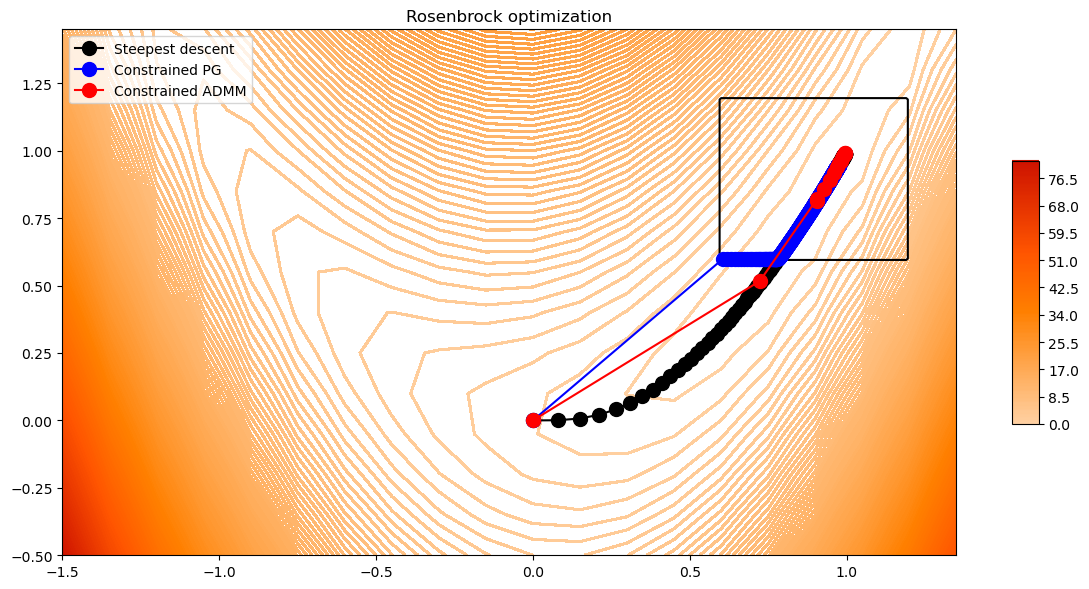

In [27]:
fig, ax = contour_rosenbrock(x, y)
ax.contour(X, Y, indic, colors='k')
ax.plot(steps[::2, 0], steps[::2, 1], '.-k', ms=20, label='Steepest descent')
ax.plot(xhist_pg[::2, 0], xhist_pg[::2, 1], '.-b', ms=20, label='Constrained PG')
ax.plot(xhist_admm[::2, 0], xhist_admm[::2, 1], '.-r', ms=20, label='Constrained ADMM')
ax.set_title('Rosenbrock optimization')
ax.legend(loc='upper left')
ax.set_xlim(x[0], x[-1])
ax.set_ylim(y[0], y[-1])
fig.tight_layout()